In [1]:
# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Misc
import datetime
import os
from platform import python_version
import random
import warnings

# EDA Tools
import ppscore as pps #<! See https://github.com/8080labs/ppscore -> pip install git+https://github.com/8080labs/ppscore.git

# Machine Learning
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
# from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import confusion_matrix, fbeta_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedGroupKFold, train_test_split

# Ensemble Engines
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from bokeh.plotting import figure, show

# Jupyter
from ipywidgets import interact, Dropdown, Layout

In [2]:
# Configuration
%matplotlib inline

warnings.filterwarnings("ignore")

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

sns.set_theme() #>! Apply SeaBorn theme

In [3]:
# Constants

DATA_FOLDER_NAME    = 'BlockChainAttacksDataSet'
DATA_FOLDER_PATTERN = 'DataSet0'
DATA_FILE_EXT       = 'csv'

PROJECT_DIR_NAME = 'CyVers' #<! Royi: Anton, don't change it, it should be a team constant
PROJECT_DIR_PATH = os.path.join(os.getcwd()[:os.getcwd().find(PROJECT_DIR_NAME)], PROJECT_DIR_NAME) #>! Pay attention, it will create issues in cases you name the folder `CyVersMe` or anything after / before `CyVers`

# Feature extractors constants

TRAIN_BY_TSX    = 1
TRAIN_BY_FILES  = 2

In [4]:
# CyVers Packages
from DataSetsAuxFun import *

In [5]:
# Parameters
dataSetRotoDir = os.path.join(PROJECT_DIR_PATH, DATA_FOLDER_NAME)

# Features Analysis
numCrossValPps = 4

# Training
trainMode = TRAIN_BY_FILES
testSetRatio = 1 / 3
numKFolds = 3
gridSearchScore = 'f1' #<! Use strings from `sklearn.metrics.get_scorer_names()`
gridSearchScore = 'recall' #<! We need to have better PD

# Amount USD Outlier threshold
amountUsdOutlierThr = 1e9

randomState = 42

lSlctedFeaturesRaw    = ['Amount', 'Currency', 'Currency Type', 'Amount [USD]', 'Receiver Type', 'Gas Price', 'Gas Limit', 'Gas Used' ]#lSlctedFeaturesRaw    = ['Amount', 'Currency', 'Amount [USD]', 'Receiver Type']
lSlctedFeaturesCalc   = [enumObj.name for enumObj in FeatureName if ((enumObj is not FeatureName.TIME_MAX) and (enumObj is not FeatureName.TIME_MIN))]
lSlctdFeatures        = lSlctedFeaturesRaw + lSlctedFeaturesCalc
lCatFeatures          = ['Currency', 'Currency Type', 'Receiver Type']#lCatFeatures          = ['Currency', 'Receiver Type']
# lFeaturesRemove       = [FeatureName.TIME_MAX.name, FeatureName.TIME_MIN.name] #<! Auxiliary features to be removed before processing

timeColStr = 'Block Time'

In [6]:
# Loading / Generating Data
lCsvFile = ExtractCsvFiles(dataSetRotoDir, folderNamePattern = DATA_FOLDER_PATTERN)
print(f'The number of file found: {len(lCsvFile)}')

# dfData = pd.read_csv(os.path.join(DATA_FOLDER_NAME, csvFileName))
dfData, dAssetFile = LoadCsvFilesDf(lCsvFile, baseFoldePath = '', addFileNameCol = True)
numRows, numCols = dfData.shape

print(f"The number of rows (Samples): {numRows}, The number of columns: {numCols}, number of unique sender id's: {dfData['Sender ID'].unique().shape}")
print(f'The data list of columns is: {dfData.columns} with {len(dfData.columns)} columns')

The number of file found: 328
The number of rows (Samples): 1845647, The number of columns: 20, number of unique sender id's: (328,)
The data list of columns is: Index(['Transaction ID', 'Transaction Time', 'Block Time', 'Sender ID',
       'Receiver ID', 'Receiver Type', 'Amount', 'Currency', 'Currency Hash',
       'Currency Type', 'Amount [USD]', 'Gas Price', 'Gas Limit', 'Gas Used',
       'Gas Predicted', 'Balance In', 'Balance Out', 'Label', 'Risk Level',
       'File Name'],
      dtype='object') with 20 columns


In [7]:
# Convert time data into Pandas format
dfData[timeColStr] = pd.to_datetime(dfData[timeColStr], infer_datetime_format = 'True') #<! Stable time format

In [8]:
# Sort data by transaction date
dfData.sort_values(timeColStr, inplace = True)
# dfData.reset_index(drop = True, inplace = True)

In [9]:
# Meet the data
dfData.head(20)

,Transaction ID,Transaction Time,Block Time,Sender ID,Receiver ID,Receiver Type,Amount,Currency,Currency Hash,Currency Type,Amount [USD],Gas Price,Gas Limit,Gas Used,Gas Predicted,Balance In,Balance Out,Label,Risk Level,File Name
905528,0x2971c7bcbf18c57a2879b07a0f6dbbc14b7c928a0335...,NaN,2016-02-12 11:01:25+00:00,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,Wallet,0.500000,ETH,0x0000000000000000000000000000000000000000,NaN,2.737825,5.000000e-08,121000.0,21000,NaN,NaN,NaN,0,NaN,Furucombo006.csv
905527,0xc18b50d6311d2de6f6bfd450a38291297eb0e1c96320...,NaN,2016-05-11 09:23:12+00:00,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,0xbb9bc244d798123fde783fcc1c72d3bb8c189413,Token,50.000000,ETH,0x0000000000000000000000000000000000000000,NaN,499.065146,3.221000e-08,174091.0,74091,NaN,NaN,NaN,0,NaN,Furucombo006.csv
905526,0x29d0b83aeead81925d6df3a5c252bb759811fbc5bb5d...,NaN,2016-05-13 11:44:02+00:00,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,0x335195726ba56b51cbd5d569c0aa5ccf5c1f4e28,Wallet,26.000000,ETH,0x0000000000000000000000000000000000000000,NaN,275.227201,3.221000e-08,121000.0,21000,NaN,NaN,NaN,0,NaN,Furucombo006.csv
905525,0x292d05383a2d9150c5b24718ceef760608561469222f...,NaN,2016-05-19 07:50:40+00:00,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,0x335195726ba56b51cbd5d569c0aa5ccf5c1f4e28,Wallet,50.000000,ETH,0x0000000000000000000000000000000000000000,NaN,735.916238,2.000000e-08,121000.0,21000,NaN,NaN,NaN,0,NaN,Furucombo006.csv
905524,0x4020de95411dd43e8613588f07a8e9643093c8e9c9a2...,NaN,2016-05-20 12:29:30+00:00,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,0x335195726ba56b51cbd5d569c0aa5ccf5c1f4e28,Wallet,100.000000,ETH,0x0000000000000000000000000000000000000000,NaN,1369.368343,2.000000e-08,121000.0,21000,NaN,NaN,NaN,0,NaN,Furucombo006.csv
905523,0xde1fb69bc6f78d32413ef8cc800ee4379855636c8daa...,NaN,2016-07-20 13:30:33+00:00,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,0xbf4ed7b27f1d666546e30d74d50d173d20bca754,Smart Contract,5000.000000,DAO,0xbb9bc244d798123fde783fcc1c72d3bb8c189413,ERC20,NaN,2.000000e-08,158971.0,43971,NaN,NaN,NaN,0,NaN,Furucombo006.csv
509135,0xf8e45e7a318827cd54a415005b30fc67dc4c62e0bb42...,NaN,2016-08-03 10:46:16+00:00,0x022026b542a9aa18aae7d61c54a4c17e448fda6b,0xaa1a6e3e6ef20068f7f8d8c835d2d22fd5116444,NaN,1.000000,ETH,0x0000000000000000000000000000000000000000,NaN,10.221748,5.000000e-08,131561.0,31561,NaN,NaN,NaN,0,NaN,FakeHack137001.csv
509134,0x056b34ec266003515e00f5c4dba9e07be9acf52a2e39...,NaN,2016-08-03 11:03:28+00:00,0x022026b542a9aa18aae7d61c54a4c17e448fda6b,0xaa1a6e3e6ef20068f7f8d8c835d2d22fd5116444,NaN,1.000000,ETH,0x0000000000000000000000000000000000000000,NaN,10.221748,5.000000e-08,131561.0,31561,NaN,NaN,NaN,0,NaN,FakeHack137001.csv
509133,0x25f0d4e11d6eb9929b9ddc85a6a2485b93337d65640e...,NaN,2016-08-03 11:37:25+00:00,0x022026b542a9aa18aae7d61c54a4c17e448fda6b,0xaa1a6e3e6ef20068f7f8d8c835d2d22fd5116444,NaN,5.000000,ETH,0x0000000000000000000000000000000000000000,NaN,51.108739,5.000000e-08,131561.0,31561,NaN,NaN,NaN,0,NaN,FakeHack137001.csv
509132,0x6008875514e32a1fc5152aac6deed0482ff5527aab3d...,NaN,2016-08-03 11:48:55+00:00,0x022026b542a9aa18aae7d61c54a4c17e448fda6b,0xaa1a6e3e6ef20068f7f8d8c835d2d22fd5116444,NaN,27.000000,ETH,0x0000000000000000000000000000000000000000,NaN,275.987191,5.000000e-08,131561.0,31561,NaN,NaN,NaN,0,NaN,FakeHack137001.csv


# Pre Processing

1. Remove invalid data.
2. Remove outliers.

In [10]:
# Detecting invalid `Amount USD`

dsInValidTrnsUsd = ((dfData['Amount [USD]'] == 0) | (dfData['Amount [USD]'].isna()) | (dfData['Amount [USD]'] == ''))

print(f'Number of invalid `Amount [USD]`: {dsInValidTrnsUsd.sum()}')

Number of invalid `Amount [USD]`: 163887


In [11]:
# Remove invalid data
dfData.drop(dfData.index[dsInValidTrnsUsd], inplace = True) #<! Royi: Should we do a reset index?

In [12]:
# Detecting Outliers in the `Amount [USD]`

dsOutlierTrnsUsd = ((dfData['Amount [USD]'] >= amountUsdOutlierThr) | (dfData['Amount [USD]'] <= 0))

print(f'Number of outliers `Amount [USD]`: {dsOutlierTrnsUsd.sum()}')

Number of outliers `Amount [USD]`: 0


In [13]:
# Remove outliers
dfData.drop(dfData.index[dsOutlierTrnsUsd], inplace = True) #<! Royi: Should we do a reset index?

In [14]:
# From now on this is the data to work with
numRows, numCols = dfData.shape

print(f'The number of rows (Samples): {numRows}, The number of columns: {numCols}')

The number of rows (Samples): 1681760, The number of columns: 20


# Meet the Data

Basic infomration about the data.

In [15]:
# Initialize the Pandas Extension (Don't change the Index from now on!)
numGrps = dfData.GrpBySender.numGrps

In [16]:
# Pre Process

dfGbs = dfData.GrpBySender

### Features per Asset

In [17]:
# Features - Amount Based

sum_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_SUM)
mean_s          = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
std_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
var_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_VAR)
median_s        = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
count_s         = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT)
min_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MIN)
max_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MAX)
coint_c         = dfGbs.AggBySender(colName = dfGbs.currencyColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_COIN_TYPE)
receiver_type_c = dfGbs.AggBySender(colName = dfGbs.receiverTypeColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_RECEIVER_TYPE)

gas_pr_mean     = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_lim_mean    = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_used_mean   = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_pr_std      = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_lim_std     = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_used_std    = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_pr_med      = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_lim_med     = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_used_med    = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)


dfData[FeatureName.AMOUNT_SUM_ASSET.name]          = sum_s
dfData[FeatureName.AMOUNT_MEAN_ASSET.name]         = mean_s
dfData[FeatureName.AMOUNT_STD_ASSET.name]          = std_s
dfData[FeatureName.AMOUNT_VAR_ASSET.name]          = var_s
dfData[FeatureName.AMOUNT_MEDIAN_ASSET.name]       = median_s
dfData[FeatureName.AMOUNT_MIN_ASSET.name]          = min_s
dfData[FeatureName.AMOUNT_MAX_ASSET.name]          = max_s
dfData[FeatureName.TSX_COUNT_ASSET.name]           = count_s
dfData[FeatureName.COIN_TYPE_COUNT_ASSET.name]     = coint_c
dfData[FeatureName.RECEIVER_TYPE_COUNT_ASSET.name] = receiver_type_c

dfData[FeatureName.GAS_PRICE_MEAN_ASSET.name] = gas_pr_mean
dfData[FeatureName.GAS_PRICE_STD_ASSET.name] = gas_pr_std
dfData[FeatureName.GAS_PRICE_MEDIAN_ASSET.name] = gas_pr_med

dfData[FeatureName.GAS_LIMIT_MEAN_ASSET.name] = gas_lim_mean
dfData[FeatureName.GAS_LIMIT_STD_ASSET.name] = gas_lim_std
dfData[FeatureName.GAS_LIMIT_MEDIAN_ASSET.name] = gas_lim_med

dfData[FeatureName.GAS_USED_MEAN_ASSET.name] = gas_used_mean
dfData[FeatureName.GAS_USED_STD_ASSET.name] = gas_used_std
dfData[FeatureName.GAS_USED_MEDIAN_ASSET.name] = gas_used_med

#COIN_TYPE_COUNT_USR                 

In [18]:
# Features - Time Based

td_mean_s   = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEAN)
td_std_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_STD)
td_median_s = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEDIAN)
td_min_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MIN)
td_max_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MAX)

dfData[FeatureName.TIME_DIFF_MEAN_ASSET.name]   = td_mean_s
dfData[FeatureName.TIME_DIFF_STD_ASSET.name]    = td_std_s
dfData[FeatureName.TIME_DIFF_MEDIAN_ASSET.name] = td_median_s
dfData[FeatureName.TIME_DIFF_MIN_ASSET.name]    = td_min_s
dfData[FeatureName.TIME_DIFF_MAX_ASSET.name]    = td_max_s

### Features per User

In [19]:
# Features - Amount Based (User)

sum_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_SUM)
mean_s          = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MEAN)
std_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_STD)
var_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_VAR)
median_s        = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MEDIAN)
count_s         = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_COUNT)
min_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MIN)
max_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MAX)
coin_c          = dfGbs.AggByReceiver(colName = dfGbs.currencyColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_COIN_TYPE)
receiver_type_c = dfGbs.AggByReceiver(colName = dfGbs.receiverTypeColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_RECEIVER_TYPE) #<! Royi: We need to check why is it so important?!?!

gas_pr_mean     = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_lim_mean    = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_used_mean   = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)

gas_pr_std      = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_lim_std     = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_used_std    = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)

gas_pr_med      = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_lim_med     = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_used_med    = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)

gas_pr_quant    = dfGbs.dfSubGrpByRec[dfGbs.gasPriceColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)
gas_lim_quant   = dfGbs.dfSubGrpByRec[dfGbs.gasLimitColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)
gas_used_quant  = dfGbs.dfSubGrpByRec[dfGbs.gasUsedColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)


dfData[FeatureName.AMOUNT_SUM_USR.name]          = sum_s
dfData[FeatureName.AMOUNT_MEAN_USR.name]         = mean_s
dfData[FeatureName.AMOUNT_STD_USR.name]          = std_s
dfData[FeatureName.AMOUNT_VAR_USR.name]          = var_s
dfData[FeatureName.AMOUNT_MEDIAN_USR.name]       = median_s
dfData[FeatureName.AMOUNT_MIN_USR.name]          = min_s
dfData[FeatureName.AMOUNT_MAX_USR.name]          = max_s
dfData[FeatureName.TSX_COUNT_USR.name]           = count_s
dfData[FeatureName.COIN_TYPE_COUNT_USR.name]     = coin_c
dfData[FeatureName.RECEIVER_TYPE_COUNT_USR.name] = receiver_type_c    

dfData[FeatureName.GAS_PRICE_MEAN_USR.name] = gas_pr_mean
dfData[FeatureName.GAS_PRICE_STD_USR.name] = gas_pr_std
dfData[FeatureName.GAS_PRICE_MEDIAN_USR.name] = gas_pr_med

dfData[FeatureName.GAS_LIMIT_MEAN_USR.name] = gas_lim_mean
dfData[FeatureName.GAS_LIMIT_STD_USR.name] = gas_lim_std
dfData[FeatureName.GAS_LIMIT_MEDIAN_USR.name] = gas_lim_med

dfData[FeatureName.GAS_USED_MEAN_USR.name] = gas_used_mean
dfData[FeatureName.GAS_USED_STD_USR.name] = gas_used_std
dfData[FeatureName.GAS_USED_MEDIAN_USR.name] = gas_used_med

dfData[FeatureName.GAS_PRICE_QUANTILE_USR.name] = gas_pr_quant
dfData[FeatureName.GAS_LIMIT_QUANTILE_USR.name] = gas_lim_quant
dfData[FeatureName.GAS_USED_QUANTILE_USR.name] = gas_used_quant


In [20]:
# Features - Time Based (User)

td_mean_s   = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEAN)
td_std_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_STD)
td_median_s = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEDIAN)
td_min_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MIN)
td_max_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MAX)

dfData[FeatureName.TIME_DIFF_MEAN_USR.name]   = td_mean_s
dfData[FeatureName.TIME_DIFF_STD_USR.name]    = td_std_s
dfData[FeatureName.TIME_DIFF_MEDIAN_USR.name] = td_median_s
dfData[FeatureName.TIME_DIFF_MIN_USR.name]    = td_min_s
dfData[FeatureName.TIME_DIFF_MAX_USR.name]    = td_max_s

### Features based on Transaction Time

In [21]:
# Features - Time Based

dfData[FeatureName.TIME_HOUR.name]    = dfGbs.GetTimeVals(periodTimeType = PeriodTimeType.HOUR_DAY)
dfData[FeatureName.TIME_WEEKDAY.name] = dfGbs.GetTimeVals(periodTimeType = PeriodTimeType.DAY_WEEK)

### Features based on Ratios

In [22]:
# Ratio Based Features

dfData[FeatureName.AMOUNT_MEAN_RATIO_USR_ASSET.name]    = dfData[FeatureName.AMOUNT_MEAN_USR.name] / dfData[FeatureName.AMOUNT_MEAN_ASSET.name]
dfData[FeatureName.AMOUNT_STD_RATIO_USR_ASSET.name]    = dfData[FeatureName.AMOUNT_STD_USR.name] / dfData[FeatureName.AMOUNT_STD_ASSET.name]
dfData[FeatureName.TIME_DIFF_MEAN_RATIO_USR_ASSET.name] = dfData[FeatureName.TIME_DIFF_MEAN_USR.name] / dfData[FeatureName.TIME_DIFF_MEAN_ASSET.name]
dfData[FeatureName.TIME_DIFF_STD_RATIO_USR_ASSET.name] = dfData[FeatureName.TIME_DIFF_STD_USR.name] / dfData[FeatureName.TIME_DIFF_STD_ASSET.name]

### Features based on Frequency

In [23]:
# Frequency Based Features

dfData[FeatureName.TIME_MAX.name] = dfGbs.AggByReceiver(colName = timeColStr, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MAX)
dfData[FeatureName.TIME_MIN.name] = dfGbs.AggByReceiver(colName = timeColStr, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MIN)

dfData[FeatureName.TIME_INTERVL_USR.name] = ((dfData[FeatureName.TIME_MAX.name] - dfData[FeatureName.TIME_MIN.name])).dt.total_seconds()

# Frequency of the User Transactions
dfData[FeatureName.TSX_FREQ_HZ_USR.name] = dfData[FeatureName.TSX_COUNT_USR.name] / dfData[FeatureName.TIME_INTERVL_USR.name]

### Gas ratio features(experimental)

In [24]:
#Ratios between the user to the mean of all users.
dfData[FeatureName.GAS_PRICE_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_PRICE_MEAN_ASSET.name]
dfData[FeatureName.GAS_LIMIT_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_LIMIT_MEAN_USR.name] / dfData[FeatureName.GAS_LIMIT_MEAN_ASSET.name]
dfData[FeatureName.GAS_USED_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_USED_MEAN_USR.name] / dfData[FeatureName.GAS_USED_MEAN_ASSET.name] 
#Gas Price', 'Gas Limit', 'Gas Used'
dfData[FeatureName.GAS_PRICE_LIMIT_RATIO.name] = dfData['Gas Price'] / dfData['Gas Limit']
dfData[FeatureName.GAS_PRICE_USED_RATIO.name] = dfData['Gas Price'] / dfData['Gas Used']
dfData[FeatureName.GAS_USED_LIMIT_RATIO.name] = dfData['Gas Used'] / dfData['Gas Limit'] 

dfData[FeatureName.GAS_PRICE_LIMIT_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_LIMIT_MEAN_USR.name]
dfData[FeatureName.GAS_PRICE_USED_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_USED_MEAN_USR.name]
dfData[FeatureName.GAS_USED_LIMIT_RATIO_MEAN.name] = dfData[FeatureName.GAS_USED_MEAN_USR.name] / dfData[FeatureName.GAS_PRICE_MEAN_USR.name] 


#Compare it to 75 quantile (TSX Gas Price / Quantile(75) of Gas Price).
dfData[FeatureName.GAS_PRICE_QUANTILE_RATIO.name] = dfData['Gas Price'] / dfData[FeatureName.GAS_PRICE_QUANTILE_USR.name]
dfData[FeatureName.GAS_LIMIT_QUANTILE_RATIO.name] = dfData['Gas Limit'] / dfData[FeatureName.GAS_LIMIT_QUANTILE_USR.name]
dfData[FeatureName.GAS_USED_QUANTILE_RATIO.name] =  dfData['Gas Used'] / dfData[FeatureName.GAS_USED_QUANTILE_USR.name]

In [25]:
#Feature to indicate first transaction
dfData[FeatureName.MIN_INDICATOR.name] = 0 ; dfData.loc[dfData[timeColStr] == dfData[FeatureName.TIME_MIN.name], FeatureName.MIN_INDICATOR.name] = 1 
### TODO !!! this can be invorrect. it will need a review !!!!!! 

In [26]:
#56
#Create features based on the currency of the transactions:
# 1. The number of different types of currencies per user. <-- done previously = dfData[FeatureName.COIN_TYPE_COUNT_USR.name]
# 2. The average of the number of types of all user for an asset. <-- groupby asset , mean(number of different types of currencies per user)
# 3. The ratio between a specific user to the average of the asset. --> 1/2
    

dfData[FeatureName.COIN_TYPE_COUNT_USR_MEAN_ASSET.name]    = dfGbs.AvgByUserCoinType()
dfData[FeatureName.COIN_TYPE_USR_MEAN_ASSET_RATIO.name]  = dfData[FeatureName.COIN_TYPE_COUNT_USR.name] / dfData[FeatureName.COIN_TYPE_COUNT_USR_MEAN_ASSET.name]


## Features Pre Processing (For Training Phase)

In [27]:
dfData_ = dfData.copy(deep=True) ###<<-- I create a copy of data frame for experiment with categorical variables 

### K-fold training, using categorical variables (EXPERIMENT)

In [28]:
###### only pd.df approach is working, numpy(dtype=object) didn't work so it is not represented
#make sure below lists are defined
lNumericalFeatures = [featureName for featureName in lSlctdFeatures if featureName not in lCatFeatures]
lTotalFeatures = lNumericalFeatures + lCatFeatures
feature_types_ = ['c' if x in lCatFeatures  else 'float' for x in lTotalFeatures]#feature_types_ = ['c' if x in lCatFeatures  else float for x in lTotalFeatures]

In [29]:
# Pre Processing Data categorical mine, here dfData_ <-- is used for experiment

dfData_.replace([np.inf, -np.inf], np.nan, inplace = True)
dfData_.fillna(0, inplace = True)
dfX_ = dfData_[lSlctdFeatures].copy()

for catColName in lCatFeatures:
    dfX_[catColName] = dfX_[catColName].astype("category", copy = False)
hStdScaler = StandardScaler()
dfX_[lNumericalFeatures] = hStdScaler.fit_transform(dfX_[lNumericalFeatures])


In [30]:
mX = dfX_[lTotalFeatures]
mX.rename(columns = {'Amount [USD]':'Amount USD'}, inplace = True)
vY = dfData_['Label']


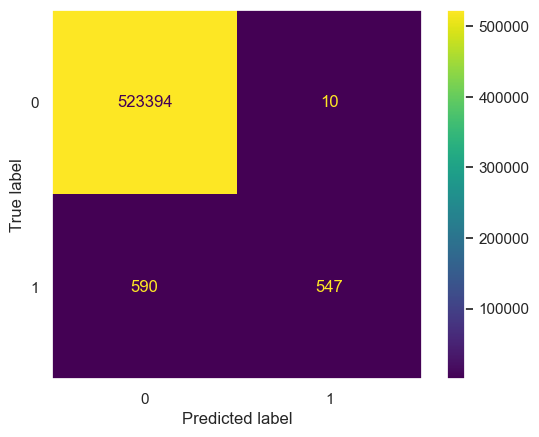

Accuracy         0.998856
F1               0.645809
Precision        0.982047
Recall           0.481091
ROC AUC Score    0.740536
dtype: float64


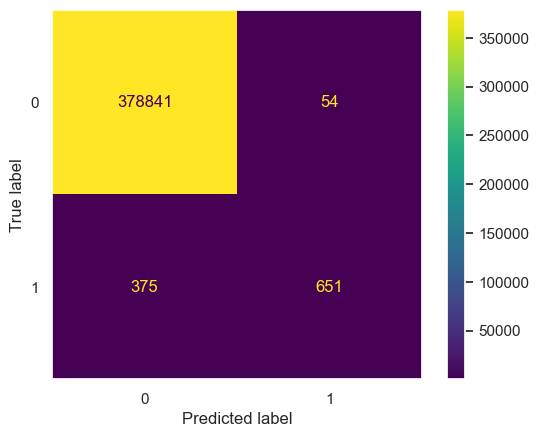

Accuracy         0.998871
F1               0.752166
Precision        0.923404
Recall           0.634503
ROC AUC Score    0.817180
dtype: float64


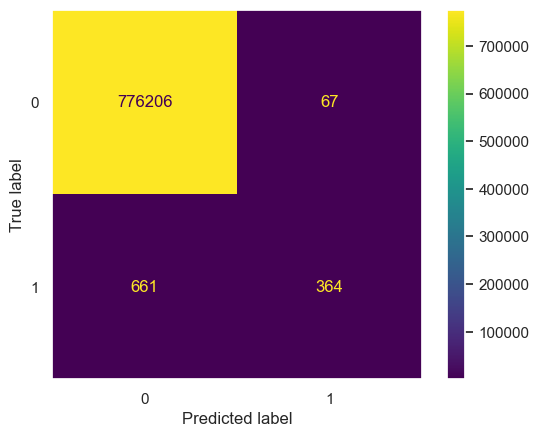

Accuracy         0.999063
F1               0.500000
Precision        0.844548
Recall           0.355122
ROC AUC Score    0.677518
dtype: float64


In [31]:
result = []

hKFoldSplt = StratifiedGroupKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)

for vTrainIdx, vTestIdx in hKFoldSplt.split(mX, vY, groups = dfData['Sender ID']):

    mXTrain, mXTest, vYTrain, vYTest = mX.iloc[vTrainIdx], mX.iloc[vTestIdx], vY.iloc[vTrainIdx], vY.iloc[vTestIdx]
    xgbModel =XGBClassifier(n_estimators=250, tree_method="hist", max_depth = 20,  random_state=seedNum, enable_categorical=True)
    xgbModel.fit(mXTrain, vYTrain)
    vYPred = xgbModel.predict(mXTest)
    DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel.classes_)
    print(GenClassifierSummaryResults(vYTest, vYPred))
    result.append([vTrainIdx, vTestIdx , xgbModel])

In [32]:
test_data = []
error_data = []
for i in result:
    test_inds = i[1]
    model = i[2]
    test_d = mX.iloc[test_inds]
    y = dfData_.iloc[test_inds]['Label']
    pred = model.predict(test_d)
    a = (y == 1) & (pred ==0)
    a = a.astype(int)
    edf =dfData_.iloc[test_inds].iloc[(a.to_numpy() > 0).nonzero()[0]][['File Name', 'Transaction ID']]##.to_csv('errors.csv')
    error_data.append(edf)

    df = dfData_.iloc[test_inds]
    df['predicted'] = pred
    df['plot_v'] = df.apply(lambda x : 0 if x['Label'] == 0 and x['predicted'] == 0 else (1 if x['Label'] == 1 and x['predicted'] == 1  else (2 if x['Label'] == 1 and x['predicted'] == 0  else 3)), axis=1)
    test_data.append(df)    

In [33]:
files_ = []
for e in error_data:
    l = e['File Name'].to_list()
    files_.extend(l)

In [34]:
files_ = list(set(files_))

In [ ]:
for f in files_:
    print(f)
    test_idxs = dfData_.index[dfData_['File Name'] == f].tolist() 
    train_idxs = dfData_.index[dfData_['File Name'] != f].tolist()

    mXTrain, mXTest, vYTrain, vYTest = mX.loc[train_idxs], mX.loc[test_idxs], vY.loc[train_idxs], vY.loc[test_idxs]
    #mXTrain, mXTest, vYTrain, vYTest = mX.iloc[train_idxs], mX.iloc[test_idxs], vY.iloc[train_idxs], vY.iloc[test_idxs]
    xgbModel_ =XGBClassifier(n_estimators=750, tree_method="hist", max_depth = 5,  random_state=seedNum, enable_categorical=True)
    xgbModel_.fit(mXTrain, vYTrain)
    vYPred = xgbModel_.predict(mXTest)
    DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel_.classes_)
    print(GenClassifierSummaryResults(vYTest, vYPred))
    

In [ ]:
result = []

hKFoldSplt = StratifiedGroupKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)

for vTrainIdx, vTestIdx in hKFoldSplt.split(mX, vY, groups = dfData['Sender ID']):

    mXTrain, mXTest, vYTrain, vYTest = mX.iloc[vTrainIdx], mX.iloc[vTestIdx], vY.iloc[vTrainIdx], vY.iloc[vTestIdx]
    xgbModel =XGBClassifier(n_estimators=250, tree_method="hist", max_depth = 20,  random_state=seedNum, enable_categorical=True)
    xgbModel.fit(mXTrain, vYTrain)
    vYPred = xgbModel.predict(mXTest)
    DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel.classes_)
    print(GenClassifierSummaryResults(vYTest, vYPred))
    result.append([vTrainIdx, vTestIdx , xgbModel])

In [ ]:
#files_.remove('Aphrodite Protocol001.csv')#pop('Aphrodite Protocol001.csv')


In [ ]:
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut
logo = LeaveOneGroupOut()

for vTrainIdx, vTestIdx in logo.split(mX, vY, groups = dfData_['File Name'].to_list()):#split(X):
    if dfData_.iloc[vTestIdx]['File Name'].to_list()[0] in files_:
        
        print(dfData_.iloc[vTestIdx]['File Name'].to_list()[0])  
        mXTrain, mXTest, vYTrain, vYTest = mX.iloc[vTrainIdx], mX.iloc[vTestIdx], vY.iloc[vTrainIdx], vY.iloc[vTestIdx]
        xgbModel =XGBClassifier(n_estimators=250, tree_method="hist", max_depth = 20,  random_state=seedNum, enable_categorical=True)
        #xgbModel =XGBClassifier(n_estimators=750, tree_method="hist", max_depth = 5,  random_state=seedNum, enable_categorical=True)
        xgbModel.fit(mXTrain, vYTrain)
        vYPred = xgbModel.predict(mXTest)
        DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel.classes_)
        print(GenClassifierSummaryResults(vYTest, vYPred))
        

In [ ]:
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut
X = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
y = np.array([1, 2, 3, 4])
groups = np.array(['a', 'a', 'b', 'b'])
logo = LeaveOneGroupOut()
logo.get_n_splits(X, y, groups)

logo.get_n_splits(groups=groups)  # 'groups' is always required

print(logo)

for train_index, test_index in logo.split(X, y, groups):
    print("TRAIN:", train_index, "TEST:", test_index)
    #X_train, X_test = X[train_index], X[test_index]
    #y_train, y_test = y[train_index], y[test_index]
    #print(X_train, X_test, y_train, y_test)

In [ ]:
import plotly.express as px

def DisplayTriFeature( dfData, xColName, yColName, zColName, fileName, legendTitle, hA = None ) -> None:
    
    if fileName != 'all':
        dfData = dfData[dfData['File Name'] == fileName ]
    dfData['plot_v'] = dfData['plot_v'].astype(str) #convert to string
    dfData['plot_v'+'_size'] = dfData['plot_v'].astype(int)
    dfData['plot_v'+'_size'] = dfData['plot_v'+'_size'] +1
    fig = px.scatter_3d(dfData, x = xColName, y = yColName, z = zColName,
                        color='plot_v' ,
                        #color_discrete_sequence=['blue', 'green','red','pink'],
                        color_discrete_map={
                                            "2": "red",
                                            "1": "green",
                                            "0": "blue",
                                            #"Oceania": "goldenrod",
                                            "3": "magenta"},
                        size='plot_v'+'_size', 
                        size_max=10, opacity=0.7) #, size=labelName, size_max=18)
    
    fig.show()
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

In [ ]:
# Display the Scatter of the Features
test_feats = lNumericalFeatures#['Amount [USD]', 'Gas Price', 'TSX Time Diff (Asset)', 'AMOUNT_SUM_USR', 'AMOUNT_MEAN_USR', 'AMOUNT_STD_USR']#, 'AMOUNT_SUM_USR', 'AMOUNT_MEAN_USR', 'AMOUNT_STD_USR']
n_ = -1
error_file_names = list(error_data[n_]['File Name'].unique()) + ['all']
df_ = test_data[n_]

oDropdwonX = Dropdown(
    options     = test_feats,#lSlctdFeatures,
    value       = 'Amount [USD]',
    description = 'Select Feature:',
    style       = {'description_width' : 'initial'}
)

oDropdwonY = Dropdown(
    options     = test_feats,#lSlctdFeatures,
    value       = 'Amount [USD]',
    description = 'Select Feature:',
    style       = {'description_width' : 'initial'}
)

oDropdwonZ = Dropdown(
    options     = test_feats,#lSlctdFeatures,
    value       = 'Amount [USD]',
    description = 'Select Feature:',
    style       = {'description_width' : 'initial'}
)

filedd = Dropdown(
    options     = error_file_names,#lSlctdFeatures,
    value       = error_file_names[0],
    description = 'Select File Name:',
    style       = {'description_width' : 'initial'}
)



label = 'test_predicted_Label_1_plot'#'train_predicted_Label_1_plot'
interact(lambda xColName, yColName, zColName , label_: DisplayTriFeature(df_ , xColName, yColName, zColName, label_, 'Suspicious' ) , xColName = oDropdwonX, yColName = oDropdwonY, zColName = oDropdwonZ , label_ = filedd)#DisplayPairFeature(dfData[test_feats], 'Label', yColName, 'Suspicious'), yColName = oDropdwon)
#interact(lambda xColName, yColName, zColName , label_: DisplayTripletFeature( dfData_.loc[dfData_[label_].isin([1,2,3]), :][test_feats + [label_]], xColName, yColName, zColName, label_, 'Suspicious' ),xColName = oDropdwonX, yColName = oDropdwonY, zColName = oDropdwonZ , label_ = labelDD)#DisplayPairFeature(dfData[test_feats], 'Label', yColName, 'Suspicious'), yColName = oDropdwon)




In [37]:
def DisplayKdeFeature_( dfData, colName, labelName, legendTitle, hA = None, fileName ='all' ) -> None:
    
    if fileName != 'all':
        dfData = dfData[dfData['File Name'] == fileName ]


    if hA is None:
        hF, hA = plt.subplots(figsize = (20, 10))
    
    sns.kdeplot(dfData[dfData[labelName] == 0][colName], ax = hA, color = 'b', label = '0')
    sns.kdeplot(dfData[dfData[labelName] == 1][colName], ax = hA, color = 'g', label = '1')
    sns.kdeplot(dfData[dfData[labelName] == 2][colName], ax = hA, color = 'r', label = '2')
    sns.kdeplot(dfData[dfData[labelName] == 3][colName], ax = hA, color = 'm', label = '3')

    hA.legend(title = legendTitle)
    plt.show()


In [38]:


test_feats = lNumericalFeatures#['Amount [USD]', 'Gas Price', 'TSX Time Diff (Asset)', 'AMOUNT_SUM_USR', 'AMOUNT_MEAN_USR', 'AMOUNT_STD_USR']#, 'AMOUNT_SUM_USR', 'AMOUNT_MEAN_USR', 'AMOUNT_STD_USR']
n_ = -1
error_file_names = list(error_data[n_]['File Name'].unique()) + ['all']
df_ = test_data[n_]

oDropdwon = Dropdown(
    options     = test_feats,
    value       = 'Amount [USD]',
    description = 'Select Feature:',
    style       = {'description_width' : 'initial'}
)

fDropdwon = Dropdown(
    options     = files_ +['all'],
    value       = 'all',
    description = 'Select Feature:',
    style       = {'description_width' : 'initial'}
)


#interact(lambda yColName, fileName: DisplayKdeFeature_(df_, yColName, 'plot_v', 'Suspicious', fileName), yColName = oDropdwon , fileName = fDropdwon )
interact(lambda yColName: DisplayKdeFeature_(df_, yColName, 'plot_v', 'Suspicious'), yColName = oDropdwon  )

interactive(children=(Dropdown(description='Select Feature:', index=1, options=('Amount', 'Amount [USD]', 'Gas…

<function __main__.<lambda>(yColName)>

In [35]:
l1 =['Amount USD',
  'Gas Price',
  'Gas Limit',
  'Gas Used',
  'AMOUNT_SUM_ASSET',
  'AMOUNT_MEAN_ASSET',
  'AMOUNT_MEAN_USR',
  'AMOUNT_STD_USR',
  'AMOUNT_VAR_USR',
  'AMOUNT_MEDIAN_ASSET',
  'AMOUNT_MEDIAN_USR',
  'AMOUNT_MIN_ASSET',
  'AMOUNT_MAX_USR',
  'TIME_DIFF_MEAN_ASSET',
  'TIME_DIFF_STD_ASSET',
  'TIME_DIFF_MEDIAN_ASSET',
  'TIME_DIFF_MAX_ASSET',
  'COIN_TYPE_COUNT_USR_MEAN_ASSET',
  'COIN_TYPE_USR_MEAN_ASSET_RATIO',
  'COIN_TYPE_COUNT_USR',
  'RECEIVER_TYPE_COUNT_ASSET',
  'TIME_HOUR',
  'TIME_WEEKDAY',
  'AMOUNT_STD_RATIO_USR_ASSET',
  'AMOUNT_MEAN_RATIO_USR_ASSET',
  'TSX_COUNT_ASSET',
  'TSX_COUNT_USR',
  'TSX_FREQ_HZ_USR',
  'GAS_PRICE_MEAN_ASSET',
  'GAS_PRICE_MEAN_USR',
  'GAS_PRICE_MEDIAN_USR',
  'GAS_LIMIT_MEAN_ASSET',
  'GAS_LIMIT_MEAN_USR',
  'GAS_LIMIT_MEDIAN_ASSET',
  'GAS_LIMIT_MEDIAN_USR',
  'GAS_USED_MEAN_ASSET',
  'GAS_USED_MEAN_USR',
  'GAS_USED_MEDIAN_ASSET',
  'GAS_USED_MEDIAN_USR',
  'MIN_INDICATOR',
  'GAS_PRICE_USR_ASSET_RATIO_MEAN',
  'GAS_LIMIT_USR_ASSET_RATIO_MEAN',
  'GAS_USED_USR_ASSET_RATIO_MEAN',
  'GAS_PRICE_LIMIT_RATIO',
  'GAS_PRICE_USED_RATIO',
  'GAS_PRICE_LIMIT_RATIO_MEAN',
  'GAS_PRICE_USED_RATIO_MEAN',
  'GAS_PRICE_QUANTILE_USR',
  'GAS_USED_QUANTILE_USR',
  'GAS_LIMIT_QUANTILE_USR']
l2 =  ['Gas Used',
  'AMOUNT_SUM_USR',
  'AMOUNT_MEAN_USR',
  'AMOUNT_STD_USR',
  'AMOUNT_MEDIAN_USR',
  'AMOUNT_MIN_USR',
  'AMOUNT_MAX_USR',
  'TIME_DIFF_MEAN_USR',
  'TIME_DIFF_STD_USR',
  'TIME_DIFF_MEDIAN_USR',
  'TIME_DIFF_MIN_USR',
  'TIME_DIFF_MAX_USR',
  'COIN_TYPE_COUNT_ASSET',
  'COIN_TYPE_USR_MEAN_ASSET_RATIO',
  'COIN_TYPE_COUNT_USR',
  'RECEIVER_TYPE_COUNT_ASSET',
  'RECEIVER_TYPE_COUNT_USR',
  'TIME_HOUR',
  'TIME_WEEKDAY',
  'TIME_INTERVL_USR',
  'AMOUNT_STD_RATIO_USR_ASSET',
  'AMOUNT_MEAN_RATIO_USR_ASSET',
  'TIME_DIFF_STD_RATIO_USR_ASSET',
  'TIME_DIFF_MEAN_RATIO_USR_ASSET',
  'TSX_COUNT_ASSET',
  'TSX_COUNT_USR',
  'TSX_FREQ_HZ_USR',
  'GAS_PRICE_MEAN_USR',
  'GAS_PRICE_STD_USR',
  'GAS_PRICE_MEDIAN_ASSET',
  'GAS_PRICE_MEDIAN_USR',
  'GAS_LIMIT_MEAN_USR',
  'GAS_LIMIT_STD_USR',
  'GAS_LIMIT_MEDIAN_ASSET',
  'GAS_LIMIT_MEDIAN_USR',
  'GAS_USED_MEAN_USR',
  'GAS_USED_STD_USR',
  'GAS_USED_MEDIAN_ASSET',
  'GAS_USED_MEDIAN_USR',
  'MIN_INDICATOR',
  'GAS_PRICE_USR_ASSET_RATIO_MEAN',
  'GAS_LIMIT_USR_ASSET_RATIO_MEAN',
  'GAS_USED_USR_ASSET_RATIO_MEAN',
  'GAS_USED_LIMIT_RATIO',
  'GAS_PRICE_LIMIT_RATIO_MEAN',
  'GAS_PRICE_USED_RATIO_MEAN',
  'GAS_USED_QUANTILE_RATIO',
  'GAS_LIMIT_QUANTILE_RATIO',
  'GAS_USED_QUANTILE_USR',
  'GAS_LIMIT_QUANTILE_USR']

  l_sfs = ['Amount',
 'Gas Price',
 'Gas Used',
 'AMOUNT_SUM_USR',
 'AMOUNT_MEAN_ASSET',
 'AMOUNT_STD_USR',
 'AMOUNT_VAR_USR',
 'AMOUNT_MIN_ASSET',
 'AMOUNT_MIN_USR',
 'AMOUNT_MAX_USR',
 'TIME_DIFF_MEAN_USR',
 'TIME_DIFF_STD_USR',
 'TIME_DIFF_MEDIAN_USR',
 'TIME_DIFF_MIN_ASSET',
 'TIME_DIFF_MIN_USR',
 'TIME_DIFF_MAX_ASSET',
 'TIME_DIFF_MAX_USR',
 'COIN_TYPE_USR_MEAN_ASSET_RATIO',
 'COIN_TYPE_COUNT_USR',
 'RECEIVER_TYPE_COUNT_USR',
 'TIME_HOUR',
 'TIME_WEEKDAY',
 'TIME_INTERVL_USR',
 'TIME_DIFF_STD_RATIO_USR_ASSET',
 'TIME_DIFF_MEAN_RATIO_USR_ASSET',
 'GAS_PRICE_STD_USR',
 'GAS_PRICE_MEDIAN_USR',
 'GAS_USED_MEAN_USR',
 'GAS_USED_STD_ASSET',
 'GAS_USED_STD_USR',
 'MIN_INDICATOR',
 'GAS_PRICE_USR_ASSET_RATIO_MEAN',
 'GAS_USED_LIMIT_RATIO',
 'GAS_PRICE_USED_RATIO_MEAN',
 'GAS_USED_LIMIT_RATIO_MEAN',
 'GAS_PRICE_QUANTILE_RATIO',
 'GAS_USED_QUANTILE_RATIO',
 'GAS_LIMIT_QUANTILE_RATIO',
 'GAS_PRICE_QUANTILE_USR',
 'GAS_USED_QUANTILE_USR']


In [36]:
sl = list(set(l1) & set(l2))

In [ ]:
sl + lCatFeatures
_mX = mX[sl + lCatFeatures]

In [ ]:

hKFoldSplt = StratifiedGroupKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
for vTrainIdx, vTestIdx in hKFoldSplt.split(_mX, vY, groups = dfData['Sender ID']):
    mXTrain, mXTest, vYTrain, vYTest = _mX.iloc[vTrainIdx], _mX.iloc[vTestIdx], vY.iloc[vTrainIdx], vY.iloc[vTestIdx]
    xgbModel =XGBClassifier(n_estimators=250, tree_method="hist", max_depth = 20,  random_state=seedNum, enable_categorical=True)
    xgbModel.fit(mXTrain, vYTrain)
    vYPred = xgbModel.predict(mXTest)
    DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel.classes_)
    print(GenClassifierSummaryResults(vYTest, vYPred))

In [ ]:
vTrainIdx = result[1][0] ;  vTestIdx = result[1][0]

In [ ]:
mx = dfData_[sl]
mXTrain, mXTest, vYTrain, vYTest = mx.iloc[vTrainIdx], mx.iloc[vTestIdx], vY.iloc[vTrainIdx], vY.iloc[vTestIdx]

In [ ]:
from sklearn import tree
treeModel = tree.DecisionTreeClassifier(max_depth = 6)
treeModel.fit(mXTrain, vYTrain)
vYPred_ = treeModel.predict(mXTest)

In [ ]:
DisplayConfusionMatrix(vYTest, vYPred_, lClasses = treeModel.classes_)
dsScoreSumm = GenClassifierSummaryResults(vYTest, vYPred_)
dfScoreSummary  = pd.DataFrame(dsScoreSumm, columns = ['Score'])
dfScoreSummary

In [ ]:
import graphviz

dot_data = tree.export_graphviz(treeModel, out_file=None, 
                                feature_names= sl,  
                                filled=True)

graph = graphviz.Source(dot_data, format="png")

In [ ]:
graph

In [ ]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

In [ ]:
import pickle


with open('tree.pickle', 'wb') as handle:
    pickle.dump(treeModel, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [50]:
x = dfData_['TIME_WEEKDAY']; y = dfData_['Label']#x = dfData_['TIME_HOUR']; y = dfData_['Label']
xtr, xt, ytr, yt = x.iloc[vTrainIdx], x.iloc[vTestIdx], y.iloc[vTrainIdx], y.iloc[vTestIdx]

In [51]:
xtr = xtr.values.reshape(-1, 1)
ytr = ytr.values.reshape(-1, 1)
xt = xt.values.reshape(-1, 1)
yt = yt.values.reshape(-1, 1)
x = x.values.reshape(-1, 1)
y = y.values.reshape(-1, 1)

In [ ]:
#from sklearn.svm import SVC
#svc = SVC(kernel='linear')
#x = x.to_numpy().reshape(1, -1) 
#y = y.reshape(1, -1)
#svc.fit(x, y)

In [52]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb = gnb.fit(xtr, ytr)
y_pred = gnb.predict(xt)


In [53]:
#gnb.predict_proba(xt)
gnb.predict_proba(np.unique(x, return_counts=True)[0].reshape(-1, 1))

array([[0.99880477, 0.00119523],
       [0.99847538, 0.00152462],
       [0.99809805, 0.00190195],
       [0.99767956, 0.00232044],
       [0.99723129, 0.00276871],
       [0.99676907, 0.00323093],
       [0.99631252, 0.00368748]])

The vector `vT` matches `vYPred`
The vector `vT` matches `vYPred`


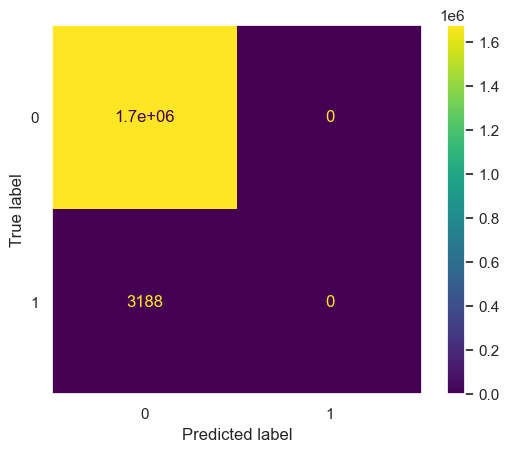

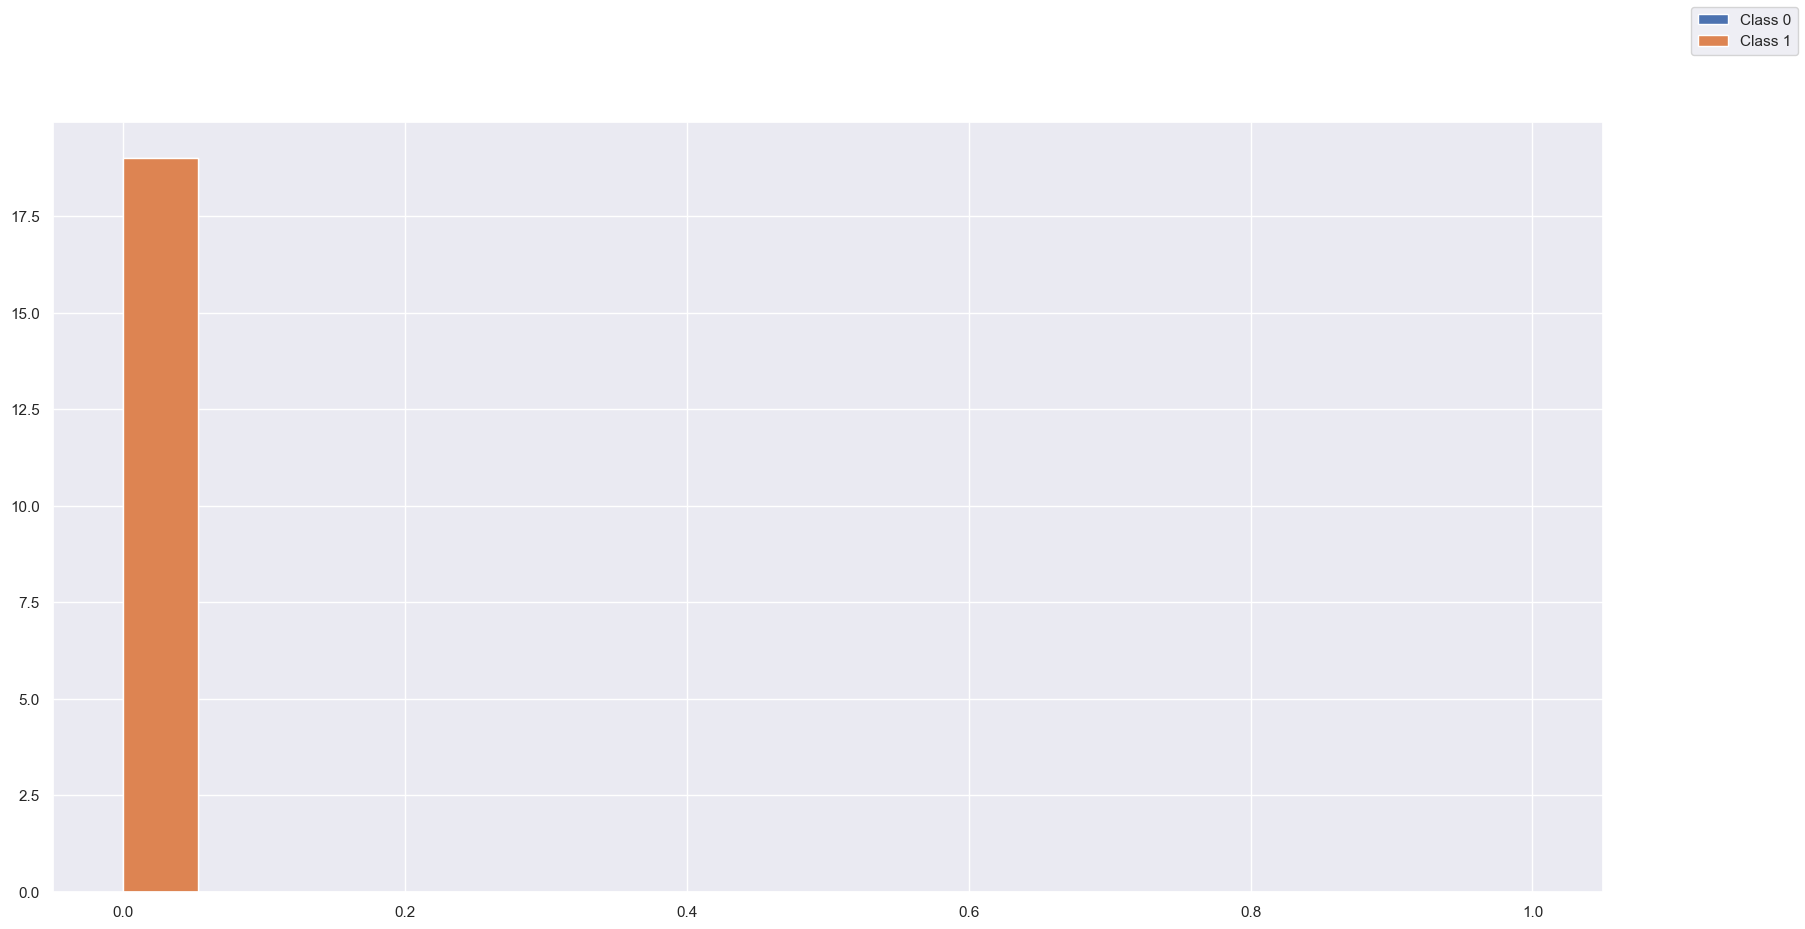

In [48]:
gnb = GaussianNB()
gnb.fit(x, y)
#xgbModel = XGBClassifier(n_estimators = 250, tree_method = 'hist', max_depth = 10,  random_state = seedNum, enable_categorical = True)
#xgbModel.fit(dfX, dsY)

mYPredProb  = gnb.predict_proba(x)#xgbModel.predict_proba(dfX)
mYPredProb  = mYPredProb / np.sum(mYPredProb, axis = 1).reshape(-1, 1) #<! To have sum of 1 (We can do better with Soft Max or calibration)
vYPredProb  = mYPredProb[:, 1] #<! Probability for Label 1
vYPred      = gnb.predict(x)#xgbModel.predict(dfX)


vT = np.argmax(mYPredProb, axis = 1)

if np.all(vT == vYPred):
    print('The vector `vT` matches `vYPred`')
else:
    print('The vector `vT` does not match `vYPred`')

vT = np.where(vYPredProb > 0.5, 1, 0)

if np.all(vT == vYPred):
    print('The vector `vT` matches `vYPred`')
else:
    print('The vector `vT` does not match `vYPred`')


# %% Analysis of Results

DisplayConfusionMatrix(y, vYPred, lClasses = gnb.classes_)

dsScoreSumm = GenClassifierSummaryResults(y, vYPred)
dfScoreSummary  = pd.DataFrame(dsScoreSumm, columns = ['Score'])
dfScoreSummary


vE = np.linspace(0, 1, 20) #<! Edges
vY0Idx = np.argwhere(y == 0)
vY1Idx = np.argwhere(y == 1)
vN0, *_ = np.histogram(vYPredProb[vY0Idx], bins = vE, density = True)
vN1, *_ = np.histogram(vYPredProb[vY1Idx], bins = vE, density = True)

# %%

edgeWidth = np.mean(np.diff(vE))

hF, hA = plt.subplots(figsize = (20, 10))
hA.bar(x = vE[:-1], height = vN0, width = edgeWidth, align = 'edge', label = 'Class 0')
hA.bar(x = vE[:-1], height = vN1, width = edgeWidth, align = 'edge', label = 'Class 1')
hF.legend()


In [ ]:

xgbModel = XGBClassifier(n_estimators = 250, tree_method = 'hist', max_depth = 10,  random_state = seedNum, enable_categorical = True)
xgbModel.fit(dfX, dsY)

vY = dsY.to_numpy()


mYPredProb  = xgbModel.predict_proba(dfX)
mYPredProb  = mYPredProb / np.sum(mYPredProb, axis = 1).reshape(-1, 1) #<! To have sum of 1 (We can do better with Soft Max or calibration)
vYPredProb  = mYPredProb[:, 1] #<! Probability for Label 1
vYPred      = xgbModel.predict(dfX)

# %% Reproduce vYPred from mYPredProb

vT = np.argmax(mYPredProb, axis = 1)

if np.all(vT == vYPred):
    print('The vector `vT` matches `vYPred`')
else:
    print('The vector `vT` does not match `vYPred`')

vT = np.where(vYPredProb > 0.5, 1, 0)

if np.all(vT == vYPred):
    print('The vector `vT` matches `vYPred`')
else:
    print('The vector `vT` does not match `vYPred`')


# %% Analysis of Results

DisplayConfusionMatrix(vY, vYPred, lClasses = xgbModel.classes_)

dsScoreSumm = GenClassifierSummaryResults(vY, vYPred)
dfScoreSummary  = pd.DataFrame(dsScoreSumm, columns = ['Score'])
dfScoreSummary

# %% Analysis of Prediction Probability

# Since the data is imbalanced, we need to process each group on its own.
vE = np.linspace(0, 1, 20) #<! Edges
vY0Idx = np.argwhere(vY == 0)
vY1Idx = np.argwhere(vY == 1)
vN0, *_ = np.histogram(vYPredProb[vY0Idx], bins = vE, density = True)
vN1, *_ = np.histogram(vYPredProb[vY1Idx], bins = vE, density = True)

# %%

edgeWidth = np.mean(np.diff(vE))

hF, hA = plt.subplots(figsize = (20, 10))
hA.bar(x = vE[:-1], height = vN0, width = edgeWidth, align = 'edge', label = 'Class 0')
hA.bar(x = vE[:-1], height = vN1, width = edgeWidth, align = 'edge', label = 'Class 1')
hF.legend()
